In [1]:
import os, sys
from glob import glob
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import interp1d, RegularGridInterpolator
from tqdm import *

import pickle

from grf.analytic_pdf import analytic_pdf

from multiprocessing import Pool 

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load plot style

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Preamble

## Load pre-computed linear matter power spectra

In [ ]:
z_compute_ary = np.logspace(-3, 3, 500)
k_ary = np.logspace(-4, np.log10(1e3), 500)

# Linear matter power spectra. 
log_pk_grid_ary = np.load("../data/log_pk_grids/log_pk_matter_grid_ary.npy")

# Create the 
log_pk_interp = RegularGridInterpolator(points=[np.log10(z_compute_ary),np.log10(k_ary)], values=log_pk_grid_ary,
                                        bounds_error=False,
                                        fill_value=None)

def log_pk_interp_fn(z_ary, k_ary):
    log_z_mesh_ary, log_k_mesh_ary = np.log10(np.meshgrid(z_ary, k_ary))
    return np.where(
        np.transpose(log_z_mesh_ary) < -3, 
        log_pk_interp(np.transpose([np.ones_like(log_z_mesh_ary) * -3., log_k_mesh_ary])), 
        log_pk_interp(np.transpose([log_z_mesh_ary, log_k_mesh_ary])) 
    )


## Produce a grid of PDF values

In [ ]:
# Range of 1+delta values over which we want the PDF.
one_plus_delt_ary = 10**np.arange(-5.1, 22.1, 0.02)

# Range of z over which we want the PDF. 
z_ary = np.logspace(-3, np.log10(200), 200)

# Number of points for log-Fourier transform in calculation of the PDF.
N_pts = 2**11
# Minimum k of the log-Fourier transform. 
k_min = 1e-5
# Maximum k of the log-Fourier transform. 
k_max = 1e10
# Smoothing radius, which we take to be the Jeans scale. 
jeans_scale_data = np.loadtxt('../data/k_bJ_ary.dat')

jeans_scale = interp1d(np.log10(jeans_scale_data[:,0]), 1./jeans_scale_data[:,1])

# Obtain the PDF with parallelization. 
pool = Pool(z_ary.size//5)

def analytic_pdf_parallel(z):
    
    res = analytic_pdf(
        one_plus_delt_ary, z, log_pk_interp_fn, 
        N_pts, k_min, k_max, jeans_scale(np.log10(z))
    )
    
    print("Completed redshift: ", z)
    
    return res

analytic_pdf_grid = list(pool.imap(analytic_pdf_parallel, z_ary))


## Generate an interpolation function for the PDF

In [ ]:
# Set zeroes in analytic_pdf_grid to a very small number to enable log-interpolation. 
analytic_pdf_grid = np.array(analytic_pdf_grid)

analytic_pdf_grid[analytic_pdf_grid == 0.] = 1e-300

log_analytic_pdf_interp = RegularGridInterpolator(
    points=[np.log10(z_ary), np.log10(one_plus_delt_ary)], values=np.log10(analytic_pdf_grid),
    bounds_error=False, fill_value=None
)

pickle.dump(log_analytic_pdf_interp, open('../data/analytic_pdf_grids/log_analytic_pdf_interp.npy', 'wb'))

In [4]:
log_analytic_pdf_interp = pickle.load(open('../data/analytic_pdf_grids/log_analytic_pdf_interp.npy', 'rb'))

def log_analytic_pdf_interp_fn(z_ary, one_plus_delt_ary):
    
    try:
        
        _ = iter(z_ary)
    
        z_ary[z_ary < 1e-3] = 1e-3 
        
    except:
        
        if z_ary < 1e-3:
            
            z_ary = 1e-3
    
    log_z_mesh_ary, log_one_plus_delt_mesh_ary = np.log10(np.meshgrid(z_ary, one_plus_delt_ary))
    
    res = log_analytic_pdf_interp(
            np.transpose([log_z_mesh_ary, log_one_plus_delt_mesh_ary])
        )
    
    res = np.where(
        (np.transpose(log_one_plus_delt_mesh_ary) < -5.) | (np.transpose(log_one_plus_delt_mesh_ary) > 22.),
        -np.inf,
        res
    )
    
    return res

[0.0001, 10000.0, 1e-10, 1000000.0]

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


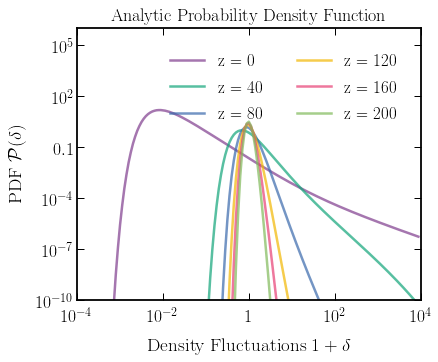

In [5]:
plt.figure()

plt.loglog()

one_plus_delt_to_plt_ary = 10**np.arange(-5, 4, 0.05)

z_to_plt_ary = np.array([0., 40., 80., 120., 160., 200.])

analytic_pdf_to_plt = 10**log_analytic_pdf_interp_fn(z_to_plt_ary, one_plus_delt_to_plt_ary)

plt_labels = ['z = 0', 'z = 40', 'z = 80', 'z = 120', 'z = 160', 'z = 200']

for z,plt_label,pdf in zip(z_to_plt_ary, plt_labels, analytic_pdf_to_plt):
    
    plt.plot(one_plus_delt_to_plt_ary, pdf, label=plt_label)
    
plt.legend(ncol=2)

plt.xlabel(r'Density Fluctuations $1+\delta$')
plt.ylabel(r'PDF $\mathcal{P}(\delta)$')

plt.title('Analytic Probability Density Function')

plt.axis([1e-4, 1e4, 1e-10, 1e6])